# Calculating negative sentiment (saltiness) from Hacker News comments using Vader
This notebook is for cleaning, modeling sentiment, and feature engineering sentiment score and rank of users and comments from a [Hacker News dataset sourced from Google BigQuery](https://console.cloud.google.com/marketplace/product/y-combinator/hacker-news).

In [1]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import re
import seaborn as sns

     |████████████████████████████████| 133kB 9.0MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Cleaning
The Hacker News dataset was split into 12 chunks so it could be stored on GitHub without exceeding the file size limit of 100mb. Here, we read in and concatenate each of those 12 datasets.

In [2]:
def load_data(seed: str = f'https://github.com/Salty-Hackers/' \
              'data-engineering/blob/main/Data/hn_',
              num: int = 11, limit: int = 500000) -> pd.DataFrame:
    
    assert isinstance(num, int), 'Num must be integer.'
    assert 0 <= num <= 11, 'Num must be between 0 and 11.'
    
    urls = [seed + f'{i}.csv?raw=true' for i in range(num)]
    cols = ['author', 'time_ts', 'text']
    df = pd.concat(
        (pd.read_csv(url, usecols=cols) for url in urls)) \
        .reset_index().drop(columns='index')
    
    # Return most recent non-NaN rows, default 500,000
    return df.dropna().sort_values(by='time_ts', ascending=False)[:limit]

In [3]:
def preprocess(df: pd.DataFrame, text_col: str ='text',
            date_col: str = 'time_ts') -> pd.DataFrame:
  """
  Takes dataframe, column (default 'text'). Returns df with no HTML, emails
  URLs, hexadecimal, or multi/leading/trailing spaces in that column.
  Renames text_col and date_col, drops microseconds from date_col, and 
  converts it to datetime.
  """

  # Make shallow copy to preserve original
  df = df[:]
  
  # Remove HTML tags
  df[text_col] = df[text_col].apply(
      lambda comment: re.sub(r'<.*?>', ' ', comment))
  
  # Remove emails
  df[text_col] = df[text_col].apply(
      lambda comment: re.sub(r'[\w.]+@\w+\.[a-z]{3}', '', comment))
  
  # Remove URLs
  df[text_col] = df[text_col].apply(
      lambda comment: re.sub(
          r'http[s]?(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
          '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', comment))
  
  # Remove punctuation encoding
  df[text_col] = df[text_col].apply(
      lambda comment: re.sub(r'&.*?;', '', comment))
  
  # Remove multi-spaces and leading/trailing whitespace characters
  df[text_col] = df[text_col].apply(
      lambda comment: re.sub(r'\s{2,}', ' ', comment).strip())
  
  # Rename text_col to 'comment'
  df = df.rename(columns={text_col: 'comment'})
  
  # Rename 'author' to 'user'
  df = df.rename(columns={'author': 'user'})
  
  # Remove microseconds from date_col
  df[date_col] = df[date_col].apply(
      lambda date: date.split('+')[0])
  
  # Convert to date_time and rename, drop date_col
  df['date_time'] = pd.to_datetime(df[date_col], infer_datetime_format=True)
  df = df.drop(columns=date_col)

  return df

In [4]:
hn_comments = preprocess(load_data())

print(hn_comments.info())
hn_comments

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 514090
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user       500000 non-null  object        
 1   comment    500000 non-null  object        
 2   date_time  500000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 15.3+ MB
None


,user,comment,date_time
0,rhaps0dy,"Im not sure how much of it has been proven, bu...",2015-10-13 08:44:02
1,pixelHD,Minecraft eh? I did the same with GTA San Andr...,2015-10-13 08:43:24
2,test1235,I think the closest universal interest for me ...,2015-10-13 08:41:45
3,copsarebastards,Why do you care about the success of the techn...,2015-10-13 08:40:45
4,spike021,What kinds of ramifications would there be if ...,2015-10-13 08:40:23
...,...,...,...
514086,donaldmcintyre,"Hi kjkdf, I did some changes, I would apprecia...",2015-06-21 21:48:12
514087,busterarm,As another separate point that Id like here bu...,2015-06-21 21:47:08
514088,omni,1. The decision making process here was unsoun...,2015-06-21 21:46:34
514089,A_COMPUTER,Arguably faking a government identification in...,2015-06-21 21:46:32


# Functions to estimate sentiment using Vader

In [5]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(comment: str) -> float:
  """
  Returns normalized composite score from [-1, 1], weighted by intensity.
  -1 is most negative, 1 is most positive.
  """
  sentiment_dict = analyzer.polarity_scores(comment)
  return sentiment_dict['compound']

In [6]:
def get_sentiment(score: float, thresh=0.05) -> str:
  """
  Engineers sentiment (positive, negative, neutral) 
  based on sentiment score [-1, 1].
  
  Default thresholds:
    positive: compound score >= 0.05
    neutral: 0.05 > compound score > -0.05
    negative: compound score <= -0.05
  """
  assert isinstance(
      score, (float, int)), 'Sentiment score must be float or int.'
  assert isinstance(
      thresh, (float, int)), 'Threshold must be float or int.'
  
  assert -1 <= score <= 1, 'Sentiment score must be between -1 and 1.'
  assert 0 < thresh < 1, 'Threshold must be between 0 and 1.'
  
  if score >= thresh:
    return 'positive'
  elif score <= -thresh:
    return 'negative'
  
  return 'neutral'

## Estimate and engineer features for sentiment

In [7]:
# First function takes around 15 minutes

# Feature engineer sentiment score for each comment
hn_comments['sentiment_score'] = hn_comments['comment'] \
.apply(lambda comment: get_sentiment_score(comment))

# Feature engineer overall sentiment for each comment
hn_comments['sentiment'] = hn_comments['sentiment_score'] \
.apply(lambda score: get_sentiment(score))

# Reorder columns so comment is first
hn_comments = hn_comments[['comment', 
                           'user', 
                           'date_time', 
                           'sentiment_score', 
                           'sentiment']
                          ]

print(hn_comments.info(), end='\n\n')
print(hn_comments.nunique())
hn_comments

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 514090
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   comment          500000 non-null  object        
 1   user             500000 non-null  object        
 2   date_time        500000 non-null  datetime64[ns]
 3   sentiment_score  500000 non-null  float64       
 4   sentiment        500000 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 22.9+ MB
None

comment            493306
user                48408
date_time          484239
sentiment_score     18816
sentiment               3
dtype: int64


,comment,user,date_time,sentiment_score,sentiment
0,"Im not sure how much of it has been proven, bu...",rhaps0dy,2015-10-13 08:44:02,0.4440,positive
1,Minecraft eh? I did the same with GTA San Andr...,pixelHD,2015-10-13 08:43:24,0.6114,positive
2,I think the closest universal interest for me ...,test1235,2015-10-13 08:41:45,0.9674,positive
3,Why do you care about the success of the techn...,copsarebastards,2015-10-13 08:40:45,0.9444,positive
4,What kinds of ramifications would there be if ...,spike021,2015-10-13 08:40:23,-0.3400,negative
...,...,...,...,...,...
514086,"Hi kjkdf, I did some changes, I would apprecia...",donaldmcintyre,2015-06-21 21:48:12,0.6696,positive
514087,As another separate point that Id like here bu...,busterarm,2015-06-21 21:47:08,0.9700,positive
514088,1. The decision making process here was unsoun...,omni,2015-06-21 21:46:34,-0.4011,negative
514089,Arguably faking a government identification in...,A_COMPUTER,2015-06-21 21:46:32,-0.8442,negative


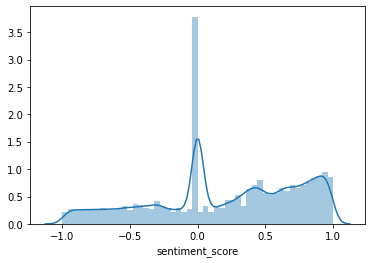

In [8]:
sns.distplot(hn_comments['sentiment_score']);

## Feature engineer average sentiment, sentiment ranking, and number of comments

In [9]:
hn_users = hn_comments.groupby(
    ['user'])['sentiment_score'].mean().reset_index()

# Reassign column names
hn_users.columns = ['user', 'avg_sentiment_score']

hn_users['num_comments'] = hn_comments['user'] \
.value_counts().sort_index().values

# Order by avg_sentiment_score then reset index so index 0 is saltiest
hn_users = hn_users \
.sort_values(by='avg_sentiment_score', axis=0, ascending=True) \
.reset_index().drop(columns='index')

# feature engineer a ranking for users: index 0 is rank 1, etc.)
hn_users['sentiment_ranking'] = hn_users['avg_sentiment_score'] \
.index.values + 1

print(hn_users.info(), end='\n\n')
print(hn_users.nunique())
hn_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48408 entries, 0 to 48407
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user                 48408 non-null  object 
 1   avg_sentiment_score  48408 non-null  float64
 2   num_comments         48408 non-null  int64  
 3   sentiment_ranking    48408 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.5+ MB
None

user                   48408
avg_sentiment_score    30183
num_comments             375
sentiment_ranking      48408
dtype: int64


,user,avg_sentiment_score,num_comments,sentiment_ranking
0,tgroshon,-0.997800,1,1
1,anonfornow,-0.997300,1,2
2,I_dont_know,-0.997000,1,3
3,Mike999,-0.996667,3,4
4,K6YtXAfA,-0.995600,1,5
...,...,...,...,...
48403,dharmon,0.999000,1,48404
48404,jwpeppa,0.999000,1,48405
48405,almaIV,0.999100,1,48406
48406,LorenzoLlamas,0.999200,1,48407


# Data Dictionary
### hn_comments
- `comment`: string, the text of a user's comment
- `user`: string, the username of the Hacker News commenter
- `date_time`: datetime, format %y/%m/%d/%H/%M/%S
- `sentiment_score`: float, Vader's composite sentiment score, normalized between [-1, 1], weighted by intensity. -1 is most negative, 1 is most positive, and 0 is most neutral.
- `sentiment`: string, the overall sentiment of the comment based on the `sentiment_score`

### hn_users
- `user`: string, the username of the Hacker News commenter
- `avg_sentiment_score`: float from [-1, 1], the arithmetic mean of the sentiment of user's comments. 
- `num_comments`: nonnegative integer, the total number of comments by a user 
- `sentiment_ranking`: positive integer, the "saltiness rank" of a user. 1 is saltiest, 2 is second saltiest, etc.

Every row in `hn_comments` is a comment, and every column is a feature of that comment.

Every row in `hn_users` is a user, and every column is a features of that user.

# Save dataframes to csv files

In [ ]:
from google.colab import files
hn_comments.to_csv('hn_comments.csv')
hn_users.to_csv('hn_users.csv')

# Save dataframes to sqlite3 database

In [ ]:
import sqlite3

conn = sqlite3.connect('hn.db')
curs = conn.cursor()
hn_users.to_sql(name='hn_users', con=conn, if_exists='replace')
hn_comments.to_sql(name='hn_comments', con=conn, if_exists='replace')